# 04 — Finite Difference Methods for Option Pricing

This notebook walks through the theory and implementation of **finite-difference PDE pricing**
for European and American options.

## Finite Difference Framework

Finite difference methods approximate the Black–Scholes–Merton (BSM) partial differential equation (PDE) by replacing derivatives with finite difference approximations.  This converts the continuous PDE into a system of algebraic difference equations.

We solve the BSM PDE **backward in time**, starting from the terminal payoff at maturity $T$ and stepping back to the pricing date $t = 0$.   Together with appropriate boundary conditions, this yields a unique numerical solution for the option value.

In practice, we construct a rectangular computational grid:

- Time grid (with $N+1$ points):
$$
t_i = i\,\Delta t, 
\quad i = 0,1,\dots,N,
\quad \text{where } \Delta t = \frac{T}{N}.
$$

- Stock price grid (with $M+1$ points):
$$
S_j = j\,\Delta S,
\quad j = 0,1,\dots,M,
\quad \text{where } \Delta S = \frac{S_{\max}}{M}.
$$

The numerical solution is then obtained by computing the option value $V_{i,j} \approx V(S_j,t_i)$ at each grid point.

**Roadmap**

1. Notebook setup (imports, parameters, grid)
2. Black–Scholes PDE and spatial difference operator $\mathcal{L}$
3. Central difference approximation for delta and gamma with $V_{i,j}$ indexing
4. Discrete operator $(\mathcal{L}V)_j$ and tridiagonal matrix form
5. Time integration over $[i\Delta t,\,(i{+}1)\Delta t]$ and backward marching
6. Explicit, implicit, and Crank–Nicolson schemes
7. Coefficient formulas $(a_j, b_j, c_j)$ and linear system assembly
8. Boundary/terminal conditions and backward solver loop
9. Stability, Rannacher smoothing, and practical notes
10. **American put option** — early exercise via PDE (PSOR solver, exercise boundary)
11. **Log-spot grid** — Itô's lemma, constant coefficients, CFL benefits, trinomial equivalence
12. **Discrete dividends** — jump condition $V(S,t_d^-)=V(S{-}D,t_d^+)$ via interpolation
13. Summary

## 1) Notebook Setup

We use the `portfolio_analytics` package for all pricing.
Key objects:

| Class / Enum | Purpose |
|---|---|
| `DiscountCurve.flat(...)` | Flat risk-free rate curve |
| `MarketData` | Bundles pricing date + discount curve |
| `UnderlyingPricingData` | Spot, vol, market data (no MC paths needed) |
| `OptionSpec` | Contract terms (type, exercise, strike, maturity) |
| `OptionValuation` | Dispatcher — routes to PDE engine |
| `PDEParams` | Grid sizes, time-stepping method, solver settings |
| `PDEMethod` | `EXPLICIT`, `IMPLICIT`, `CRANK_NICOLSON` |
| `PDESpaceGrid` | `SPOT` or `LOG_SPOT` |

In [2]:
from dataclasses import replace as dc_replace
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

from portfolio_analytics import (
    DiscountCurve,
    MarketData,
    OptionType,
    ExerciseType,
    PricingMethod,
    PDEMethod,
    PDESpaceGrid,
    PDEParams,
    OptionSpec,
    OptionValuation,
    UnderlyingPricingData,
)

In [3]:
# ── Market / contract parameters ──────────────────────────────────────
pricing_date = dt.datetime(2025, 1, 1)
maturity = dt.datetime(2026, 1, 1)

S0 = 100.0  # spot
K = 100.0  # strike (ATM)
sigma = 0.20  # volatility
r = 0.05  # risk-free rate
q = 0.02  # continuous dividend yield

# Build flat curves
T = 1.0  # year fraction (for display)
curve_r = DiscountCurve.flat(r, end_time=T)
curve_q = DiscountCurve.flat(q, end_time=T)

market_data = MarketData(pricing_date, curve_r, currency="USD")

underlying = UnderlyingPricingData(
    initial_value=S0,
    volatility=sigma,
    market_data=market_data,
    dividend_curve=curve_q,
)

call_spec = OptionSpec(
    option_type=OptionType.CALL,
    exercise_type=ExerciseType.EUROPEAN,
    strike=K,
    maturity=maturity,
    currency="USD",
)

# ── PDE grid parameters (shared across schemes) ─────────────────────
N_S = 250  # spot steps
N_t = 400  # time steps

print(f"Spot: {S0},  Strike: {K},  σ: {sigma},  r: {r},  q: {q},  T: {T}")
print(f"Grid: {N_S} spot steps × {N_t} time steps")

Spot: 100.0,  Strike: 100.0,  σ: 0.2,  r: 0.05,  q: 0.02,  T: 1.0
Grid: 250 spot steps × 400 time steps


## 2) Black–Scholes PDE and Spatial Operator $\mathcal{L}$

The PDE for option value $V(S,t)$ under risk-neutral measure with continuous dividend yield $q$ is

$$\frac{\partial V}{\partial t} + \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + (r-q)\,S\frac{\partial V}{\partial S} - r\,V = 0.$$

Define the **spatial operator**

$$\mathcal{L}V \;:=\; \frac{1}{2}\sigma^2 S^2\,V_{SS} \;+\; (r-q)\,S\,V_S \;-\; r\,V.$$

Then

$$\frac{\partial V}{\partial t} = -\mathcal{L}V \;=\; -(\text{diffusion}+\text{drift}-\text{discounting}).$$

The three terms have direct financial meaning:
- **Diffusion** $\tfrac12\sigma^2 S^2 V_{SS}$: gamma/convexity effect
- **Drift** $(r{-}q)\,S\,V_S$: risk-neutral drift (delta effect)
- **Discounting** $r\,V$: time value of money

## 3) Central Differences for Delta and Gamma with $V_{i,j}$ Indexing

We index the grid as $V_{i,j}$ where:

- $i$ is the **time** index ($t_i = i\,\Delta t$)
- $j$ is the **space** index ($S_j = j\,\Delta S$)

We march **backwards in calendar time**: at each step, $V_i$ is the unknown and $V_{i+1}$ is known (from the previous solve or from the terminal condition).

### Delta (first partial derivative)

Central difference:

$$V_S(S_j, t_i) = \frac{V_{i,j+1} - V_{i,j-1}}{2\,\Delta S} + \mathcal{O}(\Delta S^2).$$

### Gamma (second partial derivative)

$$V_{SS}(S_j, t_i) = \frac{V_{j+1} - 2V_j + V_{j-1}}{\Delta S^2} + \mathcal{O}(\Delta S^2).$$

Appendix A-1 shows how these central difference approximations are obtained.

## 4) Discrete Operator $(\mathcal{L}V)_j$ and Tridiagonal Matrix Form

Substituting finite differences into $\mathcal{L}$:

$$(\mathcal{L}V)_j = \frac{1}{2}\sigma^2 S_j^2 \frac{V_{j+1} - 2V_j + V_{j-1}}{\Delta S^2} + (r{-}q)\,S_j \frac{V_{j+1} - V_{j-1}}{2\,\Delta S} - r\,V_j.$$

Collect coefficients of $V_{j-1}$, $V_j$, $V_{j+1}$:

$$(\mathcal{L}V)_j = \gamma_j\,V_{j-1} + \beta_j\,V_j + \alpha_j\,V_{j+1},$$

where

$$\gamma_j = \frac{\sigma^2 S_j^2}{2\,\Delta S^2} - \frac{(r{-}q)\,S_j}{2\,\Delta S}, \qquad
\beta_j = -\frac{\sigma^2 S_j^2}{\Delta S^2} - r, \qquad
\alpha_j = \frac{\sigma^2 S_j^2}{2\,\Delta S^2} + \frac{(r{-}q)\,S_j}{2\,\Delta S}.$$

Note: Since $j\,\Delta S = S_j$, some textbooks replace $S_j / \Delta S = j$ in the above formulas.

### Interior nodes and the $M{-}1$ simultaneous equations

Our stock-price grid has $M{+}1$ points: $S_0, S_1, \dots, S_M$.  The values at the two **boundary** nodes — $V_{i,0}$ (at $S = 0$) and $V_{i,M}$ (at $S = S_{\max}$) — are pinned by boundary conditions at every time step (Section 8), so we already **know** them.

That leaves $M{-}1$ unknowns: $V_{i,1}, V_{i,2}, \dots, V_{i,M-1}$.  These are the **interior nodes** — the grid points strictly between the two boundaries.  Using the discrete operator above, each interior node $j$ gives one equation that links $V_{j-1}$, $V_j$, and $V_{j+1}$.  Written out for every interior node, this is a system of $M{-}1$ simultaneous equations — one per interior grid point.

### Tridiagonal matrix $L$

We can express these $M{-}1$ equations compactly in matrix form.  Define the vector of interior values $\mathbf{V} = (V_1, V_2, \dots, V_{M-1})^\top$ and the $(M{-}1)\times(M{-}1)$ matrix

$$L = \begin{bmatrix}
\beta_1 & \alpha_1 & 0 & \cdots & 0 \\
\gamma_2 & \beta_2 & \alpha_2 & \ddots & \vdots \\
0 & \ddots & \ddots & \ddots & 0 \\
\vdots & \ddots & \gamma_{M{-}2} & \beta_{M{-}2} & \alpha_{M{-}2} \\
0 & \cdots & 0 & \gamma_{M{-}1} & \beta_{M{-}1}
\end{bmatrix}.$$

This is a **tridiagonal matrix** — a special type of sparse matrix whose only non-zero entries sit on three diagonals:
- **Main diagonal** ($\beta_j$): the coefficient of $V_j$ in equation $j$
- **Superdiagonal** ($\alpha_j$): the coefficient of $V_{j+1}$ (one above the main diagonal)
- **Subdiagonal** ($\gamma_j$): the coefficient of $V_{j-1}$ (one below the main diagonal)

All other entries are zero.  With this matrix, the full system of $M{-}1$ equations is simply $(\mathcal{L}\mathbf{V}) = L\,\mathbf{V}$ (plus a small boundary-correction vector for the first and last rows, which absorb the known values $V_0$ and $V_M$).

> In `portfolio_analytics`, module `valuation.pde` builds these coefficients via
> `_spot_operator_coeffs()` (spot grid) and `_log_operator_coeffs()` (log-spot grid).

## 5) Time Integration over $[i\Delta t,\,(i{+}1)\Delta t]$ and Backward Marching

### What we're solving at each time step

We **march backwards in calendar time**: starting from the terminal payoff $\mathbf{V}_N$ (known), we step to $\mathbf{V}_{N-1}$, then $\mathbf{V}_{N-2}$, and so on, all the way back to $\mathbf{V}_0$.

At each step $i$, we already know $\mathbf{V}_{i+1}$ (the option values one step closer to maturity).  Our task is to find $\mathbf{V}_i$ — the vector of $M{-}1$ option values at the interior spot-grid points $S_1, S_2, \dots, S_{M-1}$.  The boundary values ($V_{i,0}$ and $V_{i,M}$) are given by boundary conditions, so the $M{-}1$ interior values are the only unknowns.

### From PDE to one-step update

Integrating the PDE $\partial V/\partial t = -\mathcal{L}V$ over one time step:

$$\int_{i\Delta t}^{(i+1)\Delta t} \frac{\partial V}{\partial t}\,dt = -\int_{i\Delta t}^{(i+1)\Delta t} \mathcal{L}V(S,t)\,dt,$$

$$\mathbf{V}_{i+1} - \mathbf{V}_{i} = -\int_{i\Delta t}^{(i+1)\Delta t} \mathcal{L}V\,dt.$$

The left-hand side is exact.  The different schemes arise from **how we approximate the integral on the right**.  Recall that the simplest numerical integration rules for $\int_a^b f(x)\,dx$ are:

| Rule | Formula | Error |
|---|---|---|
| Left-rectangle | $(b-a)\,f(a)$ | $\mathcal{O}(h)$ |
| Right-rectangle | $(b-a)\,f(b)$ | $\mathcal{O}(h)$ |
| Trapezoid | $\tfrac{b-a}{2}\bigl[f(a)+f(b)\bigr]$ | $\mathcal{O}(h^2)$ |

### Matching schemes to rectangle rules

The mapping is cleanest if we think in terms of **time-to-maturity** $\tau = T - t$, where we march **forward**: at each step the known value is at $\tau_k$ (left endpoint) and the unknown is at $\tau_{k+1}$ (right endpoint).  In this picture:

| Scheme | Rule (in $\tau$) | Evaluates $\mathcal{L}V$ at | Properties |
|---|---|---|---|
| **Explicit** (forward Euler) | Left-rectangle: $f(\tau_k)$ | **known** level | $\mathcal{O}(\Delta t)$, conditionally stable |
| **Implicit** (backward Euler) | Right-rectangle: $f(\tau_{k+1})$ | **unknown** level | $\mathcal{O}(\Delta t)$, unconditionally stable |
| **Crank–Nicolson** | Trapezoid: average | both levels | $\mathcal{O}(\Delta t^2)$, unconditionally stable |

Since we work in Hull's calendar-time $t$-indexing (not $\tau$), the known level is $t_{i+1}$ and the unknown is $t_i$.  The left/right labelling relative to the integration interval $[t_i, t_{i+1}]$ appears swapped compared to the $\tau$ picture — this is a common source of confusion, so in the next section we simply state which **time level** the operator is evaluated at.

The next section writes out the resulting matrix equations for each scheme.

## 6) Explicit, Implicit, and Crank–Nicolson Schemes

In each case we start from $\mathbf{V}_{i+1} - \mathbf{V}_i = -\int \mathcal{L}V\,dt$ (Section 5) and replace the integral with a rectangle or trapezoid rule.

### Explicit (forward Euler)

Evaluate $\mathcal{L}V$ at the **known** time level $t_{i+1}$ (left-rectangle in $\tau$):

$$\mathbf{V}_{i+1} - \mathbf{V}_i \approx -\Delta t\;\mathcal{L}\mathbf{V}_{i+1} = -\Delta t\;L\,\mathbf{V}_{i+1}.$$

Rearranging for the unknown $\mathbf{V}_i$:

$$\boxed{\mathbf{V}_i = (I + \Delta t\,L)\,\mathbf{V}_{i+1}.}$$

No linear system to solve — just a matrix–vector multiply.  But it has a **CFL stability condition**:
$\Delta t$ must be small enough, roughly $\Delta t \lesssim \Delta S^2 / (\sigma^2 S_{\max}^2)$.
If the stability condition is not met, often switching to a log-spot grid can be sufficient to
ensure convergence (`PDESpaceGrid.LOG_SPOT` in `portfolio_analytics`).

### Implicit (backward Euler)

Evaluate $\mathcal{L}V$ at the **unknown** time level $t_i$ (right-rectangle in $\tau$):

$$\mathbf{V}_{i+1} - \mathbf{V}_i \approx -\Delta t\;\mathcal{L}\mathbf{V}_i = -\Delta t\;L\,\mathbf{V}_i.$$

Rearranging:

$$\boxed{(I - \Delta t\,L)\,\mathbf{V}_i = \mathbf{V}_{i+1}.}$$

Because $\mathcal{L}V$ is evaluated at the unknown time level, $\mathbf{V}_i$ appears on **both** sides, which is why we end up with a linear system to solve.  Unconditionally stable — no restriction on $\Delta t$.

> Seeing $(I - \Delta t\,L)\,\mathbf{V}_i = \mathbf{V}_{i+1}$, one might think to solve
> this system we compute $(I - \Delta t\,L)^{-1}$ and pre-multiply both sides. But forming a
> matrix inverse is $\mathcal{O}(M^3)$, which is prohibitively expensive when $M$ is large.  Because
> $(I - \Delta t\,L)$ is **tridiagonal**, we can instead use the **Thomas algorithm** —
> a specialised Gaussian elimination that exploits the three-diagonal structure to solve
> the system in $\mathcal{O}(M)$ time, using only a forward sweep (elimination) and a
> backward sweep (substitution).

### Crank–Nicolson

**Trapezoid rule** — average of $\mathcal{L}V$ at both time levels:

$$\mathbf{V}_{i+1} - \mathbf{V}_i \approx -\frac{\Delta t}{2}\bigl[\mathcal{L}\mathbf{V}_i + \mathcal{L}\mathbf{V}_{i+1}\bigr] = -\frac{\Delta t}{2}\bigl[L\,\mathbf{V}_i + L\,\mathbf{V}_{i+1}\bigr].$$

Collecting unknowns on the left and knowns on the right:

$$\boxed{\left(I - \tfrac{1}{2}\Delta t\,L\right)\,\mathbf{V}_i = \left(I + \tfrac{1}{2}\Delta t\,L\right)\,\mathbf{V}_{i+1}.}$$

Second-order in time ($\mathcal{O}(\Delta t^2)$) but can produce **spurious oscillations** near non-smooth payoffs (e.g. at the kink of a call payoff at $S = K$).

> **Rannacher smoothing** (used by default in `portfolio_analytics`): replace the first few
> CN steps with implicit half-steps to dampen oscillations while preserving $\mathcal{O}(\Delta t^2)$
> convergence overall.


### Explicit Hull
The `pde` module in `portfolio_analytics` also supports the enum `PDEMethod.EXPLICIT_HULL`. This is a variation of the
pure explicit method where implicit discounting is used. In other words the diffusion and drift terms are evaluated
at $t_{i+1}$ but the $rV$ term is evaluated at $t_{i}$. When this is the case, the $r$ drops out of the $\beta_{j}$ term and all coefficients in $L$ are multiplied by $1/(1+r\Delta t)$. Thus we compute
$$
\mathbf{V}_i = \left(I + \frac{\Delta t}{1 + r\Delta t}\, L\right)\mathbf{V}_{i+1}.
$$

## 7) Coefficient Formulas $(a_j, b_j, c_j)$ and Linear System Assembly

Expanding $(I - \Delta t\,L)\,\mathbf{V}_i = \mathbf{V}_{i+1}$ row by row, the equation for interior node $j$ is

$$a_j\,V_{i,j-1} + b_j\,V_{i,j} + c_j\,V_{i,j+1} = V_{i+1,j},$$

where the **scaled coefficients** absorb the $\Delta t$ and identity matrix:

$$a_j = -\Delta t\,\gamma_j, \qquad b_j = 1 - \Delta t\,\beta_j, \qquad c_j = -\Delta t\,\alpha_j.$$

This is a tridiagonal system $(a, b, c)$ of size $M{-}1$, solved in $\mathcal{O}(M)$ by the Thomas algorithm (see Section 6).

For **Crank–Nicolson** the left-hand side uses the half-scaled coefficients $a_j' = -\tfrac{\Delta t}{2}\gamma_j$ etc., and the right-hand side is $(I + \tfrac{1}{2}\Delta t\,L)\,\mathbf{V}_{i+1}$ — a matrix–vector product using the same half-scaled operator.

> In `portfolio_analytics`, the Thomas solver is `_solve_tridiagonal_thomas()` in `valuation.pde`.
> Coefficients are built by `_scaled_operator_coeffs()` and time steps dispatched by
> `_implicit_cn_step()` and `_explicit_step()`.

## 8) Boundary/Terminal Conditions and Backward Solver Loop

### Terminal condition ($\tau = 0$, i.e. at maturity)

$$V(S, T) = \max(S - K, 0) \quad \text{(call)}, \qquad V(S, T) = \max(K - S, 0) \quad \text{(put)}.$$

### Boundary conditions (at each time step)

| Boundary | Call | Put |
|---|---|---|
| $S = 0$ | $V = 0$ | $V = K\,e^{-r\tau}$ (European) or $K$ (American) |
| $S = S_{\max}$ | $V = \max\!\bigl(S_{\max}\,e^{-q\tau} - K\,e^{-r\tau},\; 0\bigr)$ | $V = 0$ |

For **American calls** at $S = S_{\max}$, the boundary is
$V = \max\!\bigl(S_{\max}\,e^{-q\tau} - K\,e^{-r\tau},\; S_{\max} - K\bigr)$
(the greater of continuation and intrinsic).

### Backward marching

Starting from $V_N = \text{payoff}$, march $i = N{-}1, N{-}2, \dots, 0$:
1. Compute boundary values at $t_i$
2. Build RHS from $V_{i+1}$
3. Solve tridiagonal system for $V_i$
4. (American) project: $V_i \leftarrow \max(V_i, \text{intrinsic})$

Let's now run the three schemes via `portfolio_analytics`:

In [4]:
# ── Animated FD grid: backward marching visualisation ────────────────
import plotly.graph_objects as go

# Small illustrative grid (not the real 250×400 grid)
N_time, N_spot = 12, 10
t_nodes = np.linspace(0, T, N_time + 1)
s_nodes = np.linspace(0, 2 * K, N_spot + 1)
T_grid, S_grd = np.meshgrid(t_nodes, s_nodes)

# Intrinsic payoff curve (call) along right edge
spot_at_maturity = np.linspace(0, 2 * K, 200)
payoff_at_maturity = np.maximum(spot_at_maturity - K, 0.0)

S_max = 2 * K

# ── Build base figure ────────────────────────────────────────────────
fig_anim = go.Figure()

# All grid dots (static background)
fig_anim.add_trace(
    go.Scatter(
        x=T_grid.ravel(),
        y=S_grd.ravel(),
        mode="markers",
        marker=dict(size=5, color="grey", opacity=0.35),
        name="Grid points",
        hoverinfo="skip",
    )
)

# Terminal payoff curve
fig_anim.add_trace(
    go.Scatter(
        x=[T] * len(spot_at_maturity),
        y=spot_at_maturity,
        mode="lines",
        line=dict(color="steelblue", width=2),
        name="Intrinsic payoff",
        customdata=payoff_at_maturity,
        hovertemplate="S=%{y:.0f}  payoff=%{customdata:.1f}<extra></extra>",
    )
)

# Boundary lines: S=0 and S=S_max (horizontal blue lines)
fig_anim.add_trace(
    go.Scatter(
        x=[0, T],
        y=[0, 0],
        mode="lines",
        line=dict(color="steelblue", width=2),
        name="Boundary S=0",
        hoverinfo="skip",
    )
)
fig_anim.add_trace(
    go.Scatter(
        x=[0, T],
        y=[S_max, S_max],
        mode="lines",
        line=dict(color="steelblue", width=2),
        name="Boundary S=S_max",
        hoverinfo="skip",
    )
)

# Current spot marker at t=0
fig_anim.add_trace(
    go.Scatter(
        x=[0],
        y=[S0],
        mode="markers",
        marker=dict(size=10, color="red", symbol="circle"),
        name=f"Current spot S₀={S0:.0f}",
    )
)

# Highlighted column (animated) — starts empty (trace index = 5)
fig_anim.add_trace(
    go.Scatter(
        x=[],
        y=[],
        mode="markers",
        marker=dict(size=10, color="rgba(220,60,60,0.7)", symbol="square"),
        name="Solving column",
    )
)

# ── Build animation frames ──────────────────────────────────────────
# We march backward in calendar time: T → T-Δt → ... → 0
# Slider labels show the calendar time t being solved for (increasing left to right)
ANIM_TRACE_IDX = 5  # index of the animated "Solving column" trace

frames = []

# Frame 0: terminal condition known (rightmost column, t=T)
frames.append(
    go.Frame(
        data=[
            go.Scatter(
                x=[T] * (N_spot + 1),
                y=s_nodes,
                mode="markers",
                marker=dict(size=10, color="rgba(60,120,200,0.7)", symbol="square"),
                name="Known (terminal)",
            )
        ],
        traces=[ANIM_TRACE_IDX],
        name=f"t = {T:.2f} (payoff)",
    )
)

# Frames 1..N_time: march backward, highlighting each column
for step, col_idx in enumerate(range(N_time - 1, -1, -1), start=1):
    t_col = t_nodes[col_idx]
    label = f"t = {t_col:.2f}" if col_idx > 0 else "t = 0.00"
    colour = "rgba(220,60,60,0.7)" if col_idx > 0 else "rgba(220,60,60,0.95)"
    sz = 10 if col_idx > 0 else 13
    frames.append(
        go.Frame(
            data=[
                go.Scatter(
                    x=[t_col] * (N_spot + 1),
                    y=s_nodes,
                    mode="markers",
                    marker=dict(size=sz, color=colour, symbol="square"),
                    name="Solving column",
                )
            ],
            traces=[ANIM_TRACE_IDX],
            name=label,
        )
    )

fig_anim.frames = frames

# ── Slider + play/pause buttons ─────────────────────────────────────
slider_steps = [
    dict(
        args=[[f.name], dict(frame=dict(duration=400, redraw=True), mode="immediate")],
        label=round(t_nodes[i], 2),
        method="animate",
    )
    for i, f in enumerate(frames)
]

fig_anim.update_layout(
    sliders=[
        dict(active=0, steps=slider_steps, currentvalue=dict(prefix="Step: "), pad=dict(t=60))
    ],
    updatemenus=[
        dict(
            type="buttons",
            showactive=False,
            x=0.05,
            y=1.4,
            buttons=[
                dict(
                    label="▶ Play",
                    method="animate",
                    args=[None, dict(frame=dict(duration=400, redraw=True), fromcurrent=True)],
                ),
                dict(
                    label="⏸ Pause",
                    method="animate",
                    args=[[None], dict(frame=dict(duration=0, redraw=False), mode="immediate")],
                ),
            ],
        )
    ],
    xaxis=dict(title="Calendar time t", range=[-0.05, T + 0.08]),
    yaxis=dict(title="Spot price S", range=[-15, S_max + 15]),
    title=dict(text="Finite Difference Grid — Backward Marching", x=0.5),
    height=550,
    width=800,
    legend=dict(x=0.85, y=1.5, bgcolor="rgba(255,255,255,0.8)", font=dict(size=10), maxheight=20),
    annotations=[
        dict(x=T + 0.04, y=K, text="Strike K", showarrow=False, font=dict(size=11, color="grey")),
        dict(
            x=T + 0.04,
            y=S_max,
            text="S_max",
            showarrow=False,
            font=dict(size=11, color="steelblue"),
        ),
        dict(x=0, y=S_max / 2 - 10, text="V_S_0", showarrow=False, font=dict(size=10, color="red")),
        # dict(x=T+0.04, y=8, text="V_N,ⱼ (payoff)", showarrow=False,
        #      font=dict(size=10, color="steelblue")),
    ],
    margin=dict(t=120, b=50, l=50, r=50),
)

fig_anim.show()

In [5]:
# ── Price with all three PDE schemes ─────────────────────────────────
# Log spot grid is used for explicit method (else a StabilityError would be raised)
results = {}

for method in [PDEMethod.IMPLICIT, PDEMethod.EXPLICIT, PDEMethod.CRANK_NICOLSON]:
    params = PDEParams(
        spot_steps=N_S,
        time_steps=N_t,
        method=method,
        space_grid=PDESpaceGrid.LOG_SPOT if method is PDEMethod.EXPLICIT else PDESpaceGrid.SPOT,
        rannacher_steps=2 if method is PDEMethod.CRANK_NICOLSON else 0,
    )
    ov = OptionValuation(
        underlying=underlying,
        spec=call_spec,
        pricing_method=PricingMethod.PDE_FD,
        params=params,
    )
    pv = ov.present_value()
    results[method.value] = pv
    print(f"{method.value:20s}  PV = {pv:.6f}")
# ── Compare against BSM analytical price ─────────────────────────────
bsm_ov = OptionValuation(
    underlying=underlying,
    spec=call_spec,
    pricing_method=PricingMethod.BSM,
)
bsm_pv = bsm_ov.present_value()
print(f"\nBSM analytical price: {bsm_pv:.6f}")
print()
for method_name, pv in results.items():
    err = pv - bsm_pv
    print(f"{method_name:20s}  error = {err:+.6f}  ({abs(err / bsm_pv) * 100:.4f}%)")

implicit              PV = 9.230206
explicit              PV = 9.222900
crank_nicolson        PV = 9.232990

BSM analytical price: 9.227006

implicit              error = +0.003200  (0.0347%)
explicit              error = -0.004106  (0.0445%)
crank_nicolson        error = +0.005984  (0.0649%)


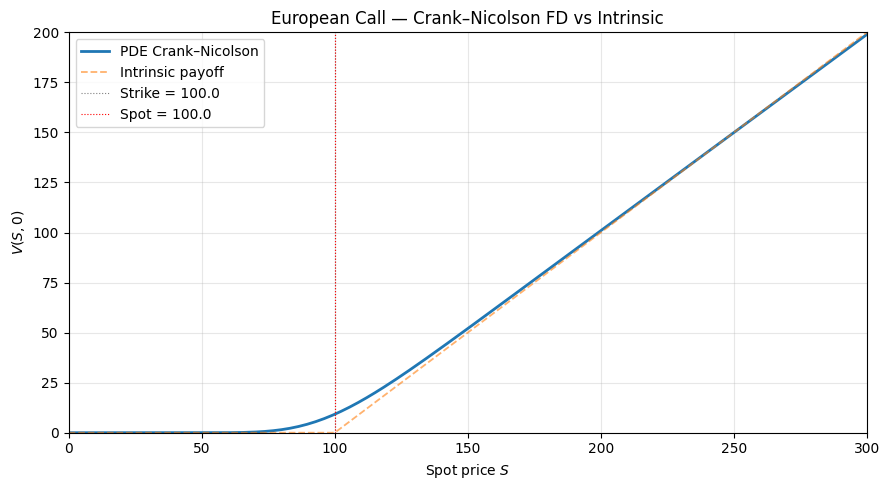

In [6]:
# ── Plot the full V(S, 0) profile for Crank–Nicolson ─────────────────
# Use the internal solve() to get the full grid
from portfolio_analytics.valuation.pde import _FDEuropeanValuation

cn_params = PDEParams(
    spot_steps=N_S,
    time_steps=N_t,
    method=PDEMethod.CRANK_NICOLSON,
    space_grid=PDESpaceGrid.SPOT,
    rannacher_steps=2,
)
ov_cn = OptionValuation(
    underlying=underlying,
    spec=call_spec,
    pricing_method=PricingMethod.PDE_FD,
    params=cn_params,
)
engine = _FDEuropeanValuation(ov_cn)
_, S_grid, V_grid = engine.solve()

# Intrinsic payoff for reference
payoff = np.maximum(S_grid - K, 0.0)

plt.figure(figsize=(9, 5))
plt.plot(S_grid, V_grid, label="PDE Crank–Nicolson", lw=2)
plt.plot(S_grid, payoff, label="Intrinsic payoff", lw=1.3, ls="--", alpha=0.6)
plt.axvline(K, color="grey", ls=":", lw=0.8, label=f"Strike = {K}")
plt.axvline(S0, color="red", ls=":", lw=0.8, label=f"Spot = {S0}")
plt.xlim(0, 3 * K)
plt.ylim(0, 2 * K)
plt.xlabel("Spot price $S$")
plt.ylabel("$V(S, 0)$")
plt.title("European Call — Crank–Nicolson FD vs Intrinsic")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## 9) Stability, Rannacher Smoothing, and Practical Notes

### Stability summary

| Scheme | Stability | Accuracy | Cost per step |
|---|---|---|---|
| **Explicit** | Conditional (CFL $\Delta t \lesssim \Delta S^2 / \sigma^2 S_{\max}^2$) | $\mathcal{O}(\Delta t, \Delta S^2)$ | $\mathcal{O}(M)$ — no solve |
| **Implicit** | Unconditional | $\mathcal{O}(\Delta t, \Delta S^2)$ | $\mathcal{O}(M)$ — Thomas algo |
| **Crank–Nicolson** | Unconditional | $\mathcal{O}(\Delta t^2, \Delta S^2)$ | $\mathcal{O}(M)$ — Thomas algo |

> `portfolio_analytics` raises `StabilityError` automatically when the explicit scheme violates
> the CFL condition.

### Rannacher smoothing

Pure Crank–Nicolson can produce **spurious oscillations** near the strike where the payoff has
a kink.  Rannacher smoothing (Pooley–Vetzal–Forsyth, 2003) replaces the first few CN intervals
with fully implicit half-steps.  This dampens the oscillations while preserving the overall
$\mathcal{O}(\Delta t^2)$ convergence rate.

In `PDEParams`, `rannacher_steps=2` (default) means the first 2 CN intervals each become
two implicit half-steps (4 implicit solves total).

---

## 10) American Put Option — Early Exercise via PDE

PDE solvers are the **industry workhorse** for American options because:

1. The backward-marching grid naturally accommodates **early exercise** — at each time step
   we project $V_i \leftarrow \max(V_i,\,\text{intrinsic})$.
2. The **free boundary** (optimal exercise boundary $S^*(t)$) falls out of the solution
   without any explicit search.
3. Computational cost is $\mathcal{O}(M \times N)$ — much cheaper than Monte Carlo for
   low-dimensional problems.

### Early exercise algorithms

`portfolio_analytics` supports two approaches:

| `PDEEarlyExercise` | Description |
|---|---|
| `INTRINSIC` | Simple max-projection after each Thomas solve (fast, slightly less accurate) |
| `GAUSS_SEIDEL` | Projected SOR (PSOR) — iterative solver that simultaneously enforces the free boundary and solves the linear system (more accurate, slower) |

We'll price an **ATM American put** (same parameters as the European call above) and compare
against the European put to see the early exercise premium.

In [9]:
# ── American put vs European put ──────────────────────────────────────
from portfolio_analytics import PDEEarlyExercise

# European put (PDE)
spec_eur_put = OptionSpec(
    option_type=OptionType.PUT,
    exercise_type=ExerciseType.EUROPEAN,
    strike=K,
    maturity=maturity,
    currency="USD",
)

pde_params_cn = PDEParams(
    spot_steps=N_S,
    time_steps=N_t,
    method=PDEMethod.CRANK_NICOLSON,
    space_grid=PDESpaceGrid.SPOT,
    rannacher_steps=2,
)

ov_eur_put = OptionValuation(
    underlying=underlying,
    spec=spec_eur_put,
    pricing_method=PricingMethod.PDE_FD,
    params=pde_params_cn,
)
pv_eur_put = ov_eur_put.present_value()

# American put (PDE) — using PSOR early exercise solver
spec_am_put = OptionSpec(
    option_type=OptionType.PUT,
    exercise_type=ExerciseType.AMERICAN,
    strike=K,
    maturity=maturity,
    currency="USD",
)

am_params = PDEParams(
    spot_steps=N_S,
    time_steps=N_t,
    method=PDEMethod.CRANK_NICOLSON,
    space_grid=PDESpaceGrid.SPOT,
    rannacher_steps=2,
    american_solver=PDEEarlyExercise.GAUSS_SEIDEL,
    omega=1.5,
    tol=1e-8,
    max_iter=20_000,
)

ov_am_put = OptionValuation(
    underlying=underlying,
    spec=spec_am_put,
    pricing_method=PricingMethod.PDE_FD,
    params=am_params,
)
pv_am_put = ov_am_put.present_value()

# BSM European put for reference
ov_bsm_put = OptionValuation(
    underlying=underlying,
    spec=spec_eur_put,
    pricing_method=PricingMethod.BSM,
)
pv_bsm_put = ov_bsm_put.present_value()

print(f"BSM European Put:       {pv_bsm_put:.6f}")
print(f"PDE European Put (CN):  {pv_eur_put:.6f}")
print(f"PDE American Put (CN):  {pv_am_put:.6f}")
print(f"\nEarly exercise premium: {pv_am_put - pv_eur_put:.6f}")
print(f"  (as % of European):   {(pv_am_put - pv_eur_put) / pv_eur_put * 100:.2f}%")

BSM European Put:       6.330081
PDE European Put (CN):  6.336066
PDE American Put (CN):  6.664814

Early exercise premium: 0.328748
  (as % of European):   5.19%


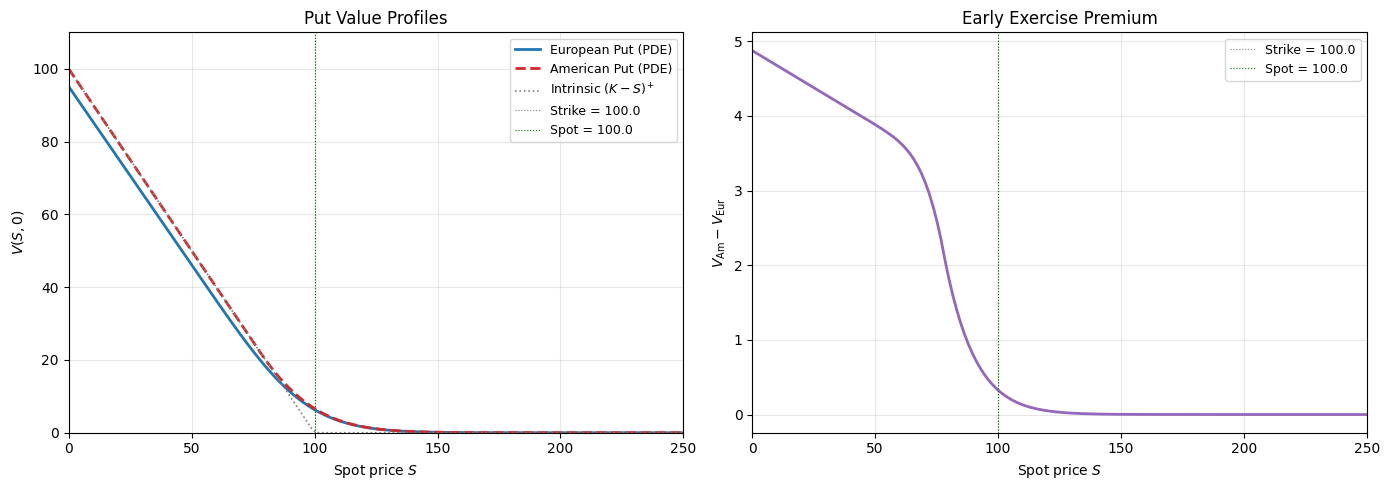

In [10]:
# ── Plot American vs European put value profiles ─────────────────────
from portfolio_analytics.valuation.pde import _FDEuropeanValuation, _FDAmericanValuation

# European put profile
engine_eur = _FDEuropeanValuation(ov_eur_put)
_, S_eur, V_eur = engine_eur.solve()

# American put profile
engine_am = _FDAmericanValuation(ov_am_put)
_, S_am, V_am = engine_am.solve()

# Intrinsic
payoff_put = np.maximum(K - S_eur, 0.0)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: value profiles
ax = axes[0]
ax.plot(S_eur, V_eur, label="European Put (PDE)", lw=2, color="tab:blue")
ax.plot(S_am, V_am, label="American Put (PDE)", lw=2, ls="--", color="tab:red")
ax.plot(S_eur, payoff_put, label="Intrinsic $(K-S)^+$", lw=1.2, ls=":", color="grey")
ax.axvline(K, color="grey", ls=":", lw=0.8, label=f"Strike = {K}")
ax.axvline(S0, color="green", ls=":", lw=0.8, label=f"Spot = {S0}")
ax.set_xlim(0, 2.5 * K)
ax.set_ylim(0, K * 1.1)
ax.set_xlabel("Spot price $S$")
ax.set_ylabel("$V(S, 0)$")
ax.set_title("Put Value Profiles")
ax.legend(fontsize=9)
ax.grid(alpha=0.3)

# Right: early exercise premium (difference)
ax2 = axes[1]
premium = V_am - V_eur
ax2.plot(S_am, premium, color="tab:purple", lw=2)
ax2.axvline(K, color="grey", ls=":", lw=0.8, label=f"Strike = {K}")
ax2.axvline(S0, color="green", ls=":", lw=0.8, label=f"Spot = {S0}")
ax2.set_xlim(0, 2.5 * K)
ax2.set_xlabel("Spot price $S$")
ax2.set_ylabel("$V_{\\mathrm{Am}} - V_{\\mathrm{Eur}}$")
ax2.set_title("Early Exercise Premium")
ax2.legend(fontsize=9)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Observations

- The **American put** value lies everywhere **above** (or equal to) the European put — early
  exercise is a right, not an obligation.
- For deep in-the-money puts (low $S$), the American value hugs the intrinsic payoff — it is
  optimal to exercise immediately.
- The **early exercise premium** peaks near the strike and vanishes for large $S$.

### The optimal exercise boundary $S^*(t)$

At each time step in the backward march, there exists a critical spot level $S^*(t)$ below
which the put holder should exercise immediately.  This **free boundary** emerges naturally
from the PDE solution: it is the point where the numerical value transitions from intrinsic
to continuation value.

> **Future work**: the solver already has `V` at every time step during backward marching.
> Adding an optional parameter to `_vanilla_fd_core` (e.g. `store_exercise_boundary=True`)
> would let us extract $S^*(t)$ in a single solve — scan each time slice for
> $\max\{j : V_j \approx \text{intrinsic}_j\}$ — rather than running many separate solves
> with different maturities.

---

## 11) Log-Spot Grid — Constant Coefficients and CFL Advantages

### Motivation

On the uniform spot grid, the operator coefficients $\gamma_j$, $\beta_j$, $\alpha_j$ depend on $S_j$ (or equivalently $j$). This means the tridiagonal matrix $L$ changes row by row and, for the explicit scheme, the CFL stability constraint

$$\Delta t \;\lesssim\; \frac{\Delta S^2}{\sigma^2 S_{\max}^2}$$

is dictated by the *largest* spot value on the grid. For a wide grid this forces very small time steps.

The fix is to **change variables** from spot $S$ to log-spot $Z = \ln S$.

### Deriving the SDE for $Z = \ln S$

Under risk-neutral GBM with continuous dividend yield $q$:

$$dS = (r - q)\,S\,dt + \sigma\,S\,dW.$$

Apply **Itô's lemma** to $Z = \ln S$ $\frac{\partial Z}{\partial S}\ = 1/S$, $\frac{\partial^2 Z}{\partial S^2} = -1/S^2$, $\frac{\partial Z}{\partial t}$ = 0 ,

$$
dZ = \bigl(r - q - \tfrac{1}{2}\sigma^2\bigr)\,dt + \sigma\,dW.
$$

Key observation: $Z$ has **constant drift** $\mu = r - q - \tfrac12\sigma^2$ and **constant diffusion** $\sigma$ — the state variable $S$ (or $Z$) has dropped out.

### The PDE in log-spot coordinates

Substituting $V(S,t) = U(Z,t)$ where $Z = \ln S$, the BS PDE becomes

$$\frac{\partial U}{\partial t} + \frac{1}{2}\sigma^2\,\frac{\partial^2 U}{\partial Z^2} + \mu\,\frac{\partial U}{\partial Z} - r\,U = 0,$$

where $\mu = r - q - \tfrac12\sigma^2$.

### Constant operator coefficients

Applying central differences on a uniform log grid with spacing $\Delta Z$:

$$\gamma = \frac{\sigma^2}{2\,\Delta Z^2} - \frac{\mu}{2\,\Delta Z}, \qquad
\beta = -\frac{\sigma^2}{\Delta Z^2} - r, \qquad
\alpha = \frac{\sigma^2}{2\,\Delta Z^2} + \frac{\mu}{2\,\Delta Z}.$$

These coefficients are **scalars** — they depend only on the parameters $(\sigma, r, q)$ and the grid spacing $\Delta Z$, **not** on the grid index $j$. This is because $S_j$ (or $Z_j$) does not appear in any of the formulas. The tridiagonal matrix $L$ is therefore *constant* (Toeplitz), which means:

- **Time and space invariant**: the same coefficients apply at every node and every time step.
- **Memory efficient**: store three scalars instead of three arrays.
- **No oscillation risk**: the CFL condition for the explicit scheme on the log grid becomes

$$\Delta t \;\leq\; \frac{\Delta Z^2}{\sigma^2},$$

which is independent of $S_{\max}$ — a dramatic improvement. This is why `portfolio_analytics` defaults to `PDESpaceGrid.LOG_SPOT` for `PDEMethod.EXPLICIT`.

### Hull's $\Delta Z$ heuristic

Hull (*Options, Futures, and Other Derivatives*) suggests

$$\Delta Z = \sigma\,\sqrt{3\,\Delta t},$$

which ensures the explicit-scheme probabilities remain strictly positive and satisfy the CFL bound with margin. This is the heuristic used by `_build_log_grid()` in `valuation.pde`.

### Constant percent change interpretation

On the spot grid, a step from $S_j$ to $S_{j+1}$ represents a constant **dollar** change $\Delta S$.

On the log grid, a step from $Z_j$ to $Z_{j+1}$ represents

$$\frac{S_{j+1} - S_j}{S_j} = e^{\Delta Z} - 1 \;\approx\; \Delta Z \quad (\text{constant percent change}).$$

This is financially natural and ensures the grid resolution is *proportionally* finer near low spot values and coarser near high spot values.

### Equivalence to the trinomial model

The explicit FD scheme on the log grid is essentially a **trinomial tree**. At each node $Z_j$, the value at the previous time step is a linear combination of three neighbours:

$$U_{i,j} = p_u\,U_{i+1,j+1} + p_m\,U_{i+1,j} + p_d\,U_{i+1,j-1},$$

where

$$p_u = \Delta t\,\alpha, \qquad p_m = 1 + \Delta t\,\beta, \qquad p_d = \Delta t\,\gamma.$$

Mapping back to spot: $S_{\text{up}} = S\,e^{\Delta Z}$, $S_{\text{mid}} = S$, $S_{\text{down}} = S\,e^{-\Delta Z}$, which is exactly the structure of a **recombining trinomial tree**. With Hull's $\Delta Z$ choice the transition probabilities match the standard trinomial tree parameterisation.

In [11]:
# ── Verify constant coefficients on the log grid ─────────────────────
# Spot grid: coefficients vary with j (arrays)
from portfolio_analytics.valuation.pde import _spot_operator_coeffs, _log_operator_coeffs

dS = 2 * K / N_S
S_interior = np.arange(1, N_S) * dS

gamma_s, beta_s, alpha_s = _spot_operator_coeffs(
    spot_values=S_interior,
    dS=dS,
    risk_free_rate=r,
    dividend_rate=q,
    volatility=sigma,
)

# Log grid: coefficients are scalars
dz = sigma * np.sqrt(3 * (T / N_t))
gamma_z, beta_z, alpha_z = _log_operator_coeffs(
    dz=dz,
    risk_free_rate=r,
    dividend_rate=q,
    volatility=sigma,
)

print("Spot grid coefficients (first 5 interior nodes):")
for j in range(5):
    print(f"  j={j + 1:3d}  γ={gamma_s[j]:+.6f}  β={beta_s[j]:+.6f}  α={alpha_s[j]:+.6f}")
print(f"  ... ({len(gamma_s)} values total — vary with j)\n")

print("Log grid coefficients (scalars, same at every node):")
print(f"  γ = {gamma_z:+.6f}")
print(f"  β = {beta_z:+.6f}")
print(f"  α = {alpha_z:+.6f}")
print(f"\n  ΔZ (Hull) = σ√(3Δt) = {dz:.6f}")
print(f"  ΔZ step ≈ {100 * (np.exp(dz) - 1):.2f}% spot change")

Spot grid coefficients (first 5 interior nodes):
  j=  1  γ=+0.005000  β=-0.090000  α=+0.035000
  j=  2  γ=+0.050000  β=-0.210000  α=+0.110000
  j=  3  γ=+0.135000  β=-0.410000  α=+0.225000
  j=  4  γ=+0.260000  β=-0.690000  α=+0.380000
  j=  5  γ=+0.425000  β=-1.050000  α=+0.575000
  ... (249 values total — vary with j)

Log grid coefficients (scalars, same at every node):
  γ = +66.377992
  β = -133.383333
  α = +66.955342

  ΔZ (Hull) = σ√(3Δt) = 0.017321
  ΔZ step ≈ 1.75% spot change


In [12]:
# ── Spot grid vs log-spot grid: price comparison ─────────────────────
# Explicit scheme on spot grid would raise StabilityError;
# on the log grid it converges without issue.

from portfolio_analytics.exceptions import StabilityError

# Try explicit on spot grid — expect failure
try:
    ov_exp_spot = OptionValuation(
        underlying=underlying,
        spec=call_spec,
        pricing_method=PricingMethod.PDE_FD,
        params=PDEParams(
            spot_steps=N_S,
            time_steps=N_t,
            method=PDEMethod.EXPLICIT,
            space_grid=PDESpaceGrid.SPOT,
        ),
    )
    ov_exp_spot.present_value()
    print("Explicit on SPOT grid: converged (unexpected)")
except StabilityError as e:
    print(f"Explicit on SPOT grid: StabilityError — {e}")

# Explicit on log grid — works fine
ov_exp_log = OptionValuation(
    underlying=underlying,
    spec=call_spec,
    pricing_method=PricingMethod.PDE_FD,
    params=PDEParams(
        spot_steps=N_S,
        time_steps=N_t,
        method=PDEMethod.EXPLICIT,
        space_grid=PDESpaceGrid.LOG_SPOT,
    ),
)
pv_exp_log = ov_exp_log.present_value()

print(f"\nExplicit on LOG_SPOT grid: PV = {pv_exp_log:.6f}")
print(f"BSM reference:             PV = {bsm_pv:.6f}")
print(
    f"Error:                         {pv_exp_log - bsm_pv:+.6f}  "
    f"({abs(pv_exp_log - bsm_pv) / bsm_pv * 100:.4f}%)"
)

Explicit on SPOT grid: StabilityError — Explicit spot-grid scheme unstable: time step too large. max_dt=0.0025 exceeds dt_max=0.0004. Increase time_steps to >= 2501 or use log-spot/implicit/CN.

Explicit on LOG_SPOT grid: PV = 9.222900
BSM reference:             PV = 9.227006
Error:                         -0.004106  (0.0445%)


---

## 12) Discrete Dividends — Jump Condition via Interpolation

### The no-arbitrage constraint

When a stock pays a known cash dividend $D$ at time $t_d$, its price drops by $D$ at the ex-dividend instant.  To prevent arbitrage, the option value just **before** the dividend must equal the option value just **after**, evaluated at the *reduced* spot:

$$V(S,\, t_d^{-}) \;=\; V(S - D,\, t_d^{+}).$$

This is a **jump condition** in the PDE solution: the value surface is continuous through $t_d$, but shifted in the $S$ direction.

### Implementation in `portfolio_analytics`

During the backward march, whenever the solver crosses an ex-dividend time $t_d$:

1. **Compute** $V(\cdot, t_d^{+})$ — the solution from the time step immediately after $t_d$.
2. **Shift** the spot grid: for each $S_j$, evaluate $V(S_j - D,\, t_d^{+})$ via linear interpolation on the existing grid.
3. **Clamp** at boundaries: for $S_j - D$ below the grid minimum, use the leftmost value; above the maximum, use the rightmost value.
4. **Continue** backward marching with the shifted values as the new state.

In code this is a single `np.interp` call:

```python
shifted = np.interp(
    S_grid - D,     # where to evaluate
    S_grid,         # known grid
    V,              # known values
    left=V[0],      # clamp below
    right=V[-1],    # clamp above
)
V[:] = shifted
```

This is implemented in `_apply_dividend_jump()` in `valuation.pde`. The time grid is augmented with the exact dividend dates in the `_build_tau_grid()` method so that the jump is applied precisely at the right backward-marching step.

### Log-spot grid handling

On the log grid $Z = \ln S$, we first convert to spot ($S = e^Z$), apply the shift $S - D$, interpolate, and write back. This preserves the uniform $\Delta Z$ spacing while correctly modelling the dollar-amount drop.

Let's see discrete dividends in action:

In [13]:
put_spec = dc_replace(call_spec, option_type=OptionType.PUT)

In [14]:
# ── Discrete dividends: PDE vs no-dividend baseline ──────────────────
# Add two cash dividends during the option's life
div_dates = [
    (dt.datetime(2025, 4, 1), 2.0),
    (dt.datetime(2025, 10, 1), 2.0),
]

underlying_div = UnderlyingPricingData(
    initial_value=S0,
    volatility=sigma,
    market_data=market_data,
    discrete_dividends=div_dates,
)

# Price with discrete dividends (Crank–Nicolson, spot grid)
for contract_spec in (call_spec, put_spec):
    ov_div = OptionValuation(
        underlying=underlying_div,
        spec=contract_spec,
        pricing_method=PricingMethod.PDE_FD,
        params=pde_params_cn,
    )
    pv_div = ov_div.present_value()

    # No-dividend reference (already computed)
    pv_no_div = OptionValuation(
        underlying=underlying,
        spec=contract_spec,
        pricing_method=PricingMethod.BSM,
    ).present_value()

    print("Contract spec:", contract_spec.option_type.name.title())
    print(f"PDE with discrete dividends:  {pv_div:.6f}")
    print(f"BSM (continuous yield only):  {pv_no_div:.6f}")
    print(f"Impact of cash dividends:     {pv_div - pv_no_div:+.6f}")
    print("\n")

Contract spec: Call
PDE with discrete dividends:  8.282719
BSM (continuous yield only):  9.227006
Impact of cash dividends:     -0.944287


Contract spec: Put
PDE with discrete dividends:  7.307743
BSM (continuous yield only):  6.330081
Impact of cash dividends:     +0.977662




---

## 13) Summary

| Topic | Key takeaway |
|---|---|
| **BS PDE** | $V_t + \tfrac12\sigma^2 S^2 V_{SS} + (r{-}q)SV_S - rV = 0$ |
| **Spatial operator** | Tridiagonal $(\gamma_j, \beta_j, \alpha_j)$ from central differences |
| **Time stepping** | Explicit (conditional), Implicit (unconditional), CN ($\mathcal{O}(\Delta t^2)$) |
| **Rannacher smoothing** | First few CN steps → implicit half-steps to dampen oscillations |
| **American options** | Max-projection or PSOR at each time step; free boundary emerges naturally |
| **Log-spot grid** | Itô → constant coefficients, CFL independent of $S_{\max}$, ≡ trinomial tree |
| **Discrete dividends** | Jump condition $V(S, t_d^-)=V(S{-}D, t_d^+)$ via `np.interp` with clamping |

**Further reading**: Wilmott, Duffy, *Finite Difference Methods in Financial Engineering* (2006);
Pooley, Vetzal, Forsyth (2003) for Rannacher smoothing; Hull Ch. 21 for the log-grid / trinomial equivalence.

### Appendix

### A.1 — Taylor expansions

### Gamma (second partial derivative)

Take 4th order Taylor expansions about the grid point $(S_j, t_i)$,
where all partial derivatives on the RHS are evaluated at $(S_j, t_i)$:

$$V(S_j{+}\Delta S,\, t_i) = V(S_j, t_i) + \Delta S\,V_S + \tfrac{1}{2}\Delta S^2\,V_{SS} + \tfrac{1}{6}\Delta S^3\,V_{SSS} + \mathcal{O}(\Delta S^4),$$

$$V(S_j{-}\Delta S,\, t_i) = V(S_j, t_i) - \Delta S\,V_S + \tfrac{1}{2}\Delta S^2\,V_{SS} - \tfrac{1}{6}\Delta S^3\,V_{SSS} + \mathcal{O}(\Delta S^4).$$

Adding them, the odd-order terms cancel:

$$V(S_j{+}\Delta S,\, t_i) + V(S_j{-}\Delta S,\, t_i) = 2\,V(S_j, t_i) + \Delta S^2\,V_{SS} + \mathcal{O}(\Delta S^4).$$

Rearranging we obtain

$$V_{SS}(S_j, t_i) = \frac{V(S_j{+}\Delta S,\, t_i) - 2\,V(S_j, t_i) + V(S_j{-}\Delta S,\, t_i)}{\Delta S^2} + \mathcal{O}(\Delta S^2).$$

On the discrete grid this becomes

$$V_{SS}(S_j, t_i) \approx \frac{V_{j+1}^{\,i} - 2V_j^{\,i} + V_{j-1}^{\,i}}{\Delta S^2}.$$

The process is similar for delta: take 3rd order expansions about $(S_j, t_i)$ and *subtract*. The odd-order terms remain and the even-order terms cancel, giving the central difference approximation for $V_S$.